# IL2233 Lab 1 - Time series analysis

## Task 1 - Exploratory Data Analysis

## Task 1.1 - White noise series

**Imports used for whole notebook**

In [6]:
import matplotlib.pyplot as plt
import time
import statsmodels.api as sm
import numpy as np
from random import gauss, seed, randint
from pandas import Series, plotting, read_excel, DataFrame
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller, acovf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from numpy.fft import fft, rfft
from scipy.io import loadmat
from scipy.signal import spectrogram
from math import sqrt

**Helper functions**

In [7]:
# Line plot, histogram, density plot, box plot, lag-1 plot, ACF and PACF graphs
def plot_all(series: Series, lags: int):
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))
    fig.subplots_adjust()

    series.plot(ax=axes[0,0], kind='line', title='Lineplot', xlabel='SV #', ylabel='Value')
    series.plot(ax=axes[0,1], kind='hist', title='Histogram', xlabel='Value', ylabel='frequency')
    series.plot(ax=axes[1,1], kind='density', title='Density', xlabel='', ylabel='density')
    series.plot(ax=axes[1,0], kind='box')
    plotting.lag_plot(series, ax=axes[2,0])
    autocorrelation_plot(series, ax=axes[2,1])
    plot_pacf(series, lags=lags, ax=axes[3,0]);

def ljungbox(series: Series):
    return sm.stats.acorr_ljungbox(series)

def adfuller_test(series: Series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'{key}, {value}')

### Task 1.1.1 - Generate a white noise series. Find mean, and standard deviation. Draw line plot, histogram, density plot, box plot lag-1 plot, ACF and PACF (lags up to 40).

MEAN:-0.07120429237582035 STDDEV: 0.9922827480232803


/home/zanilicious/anaconda3/envs/IL2233/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


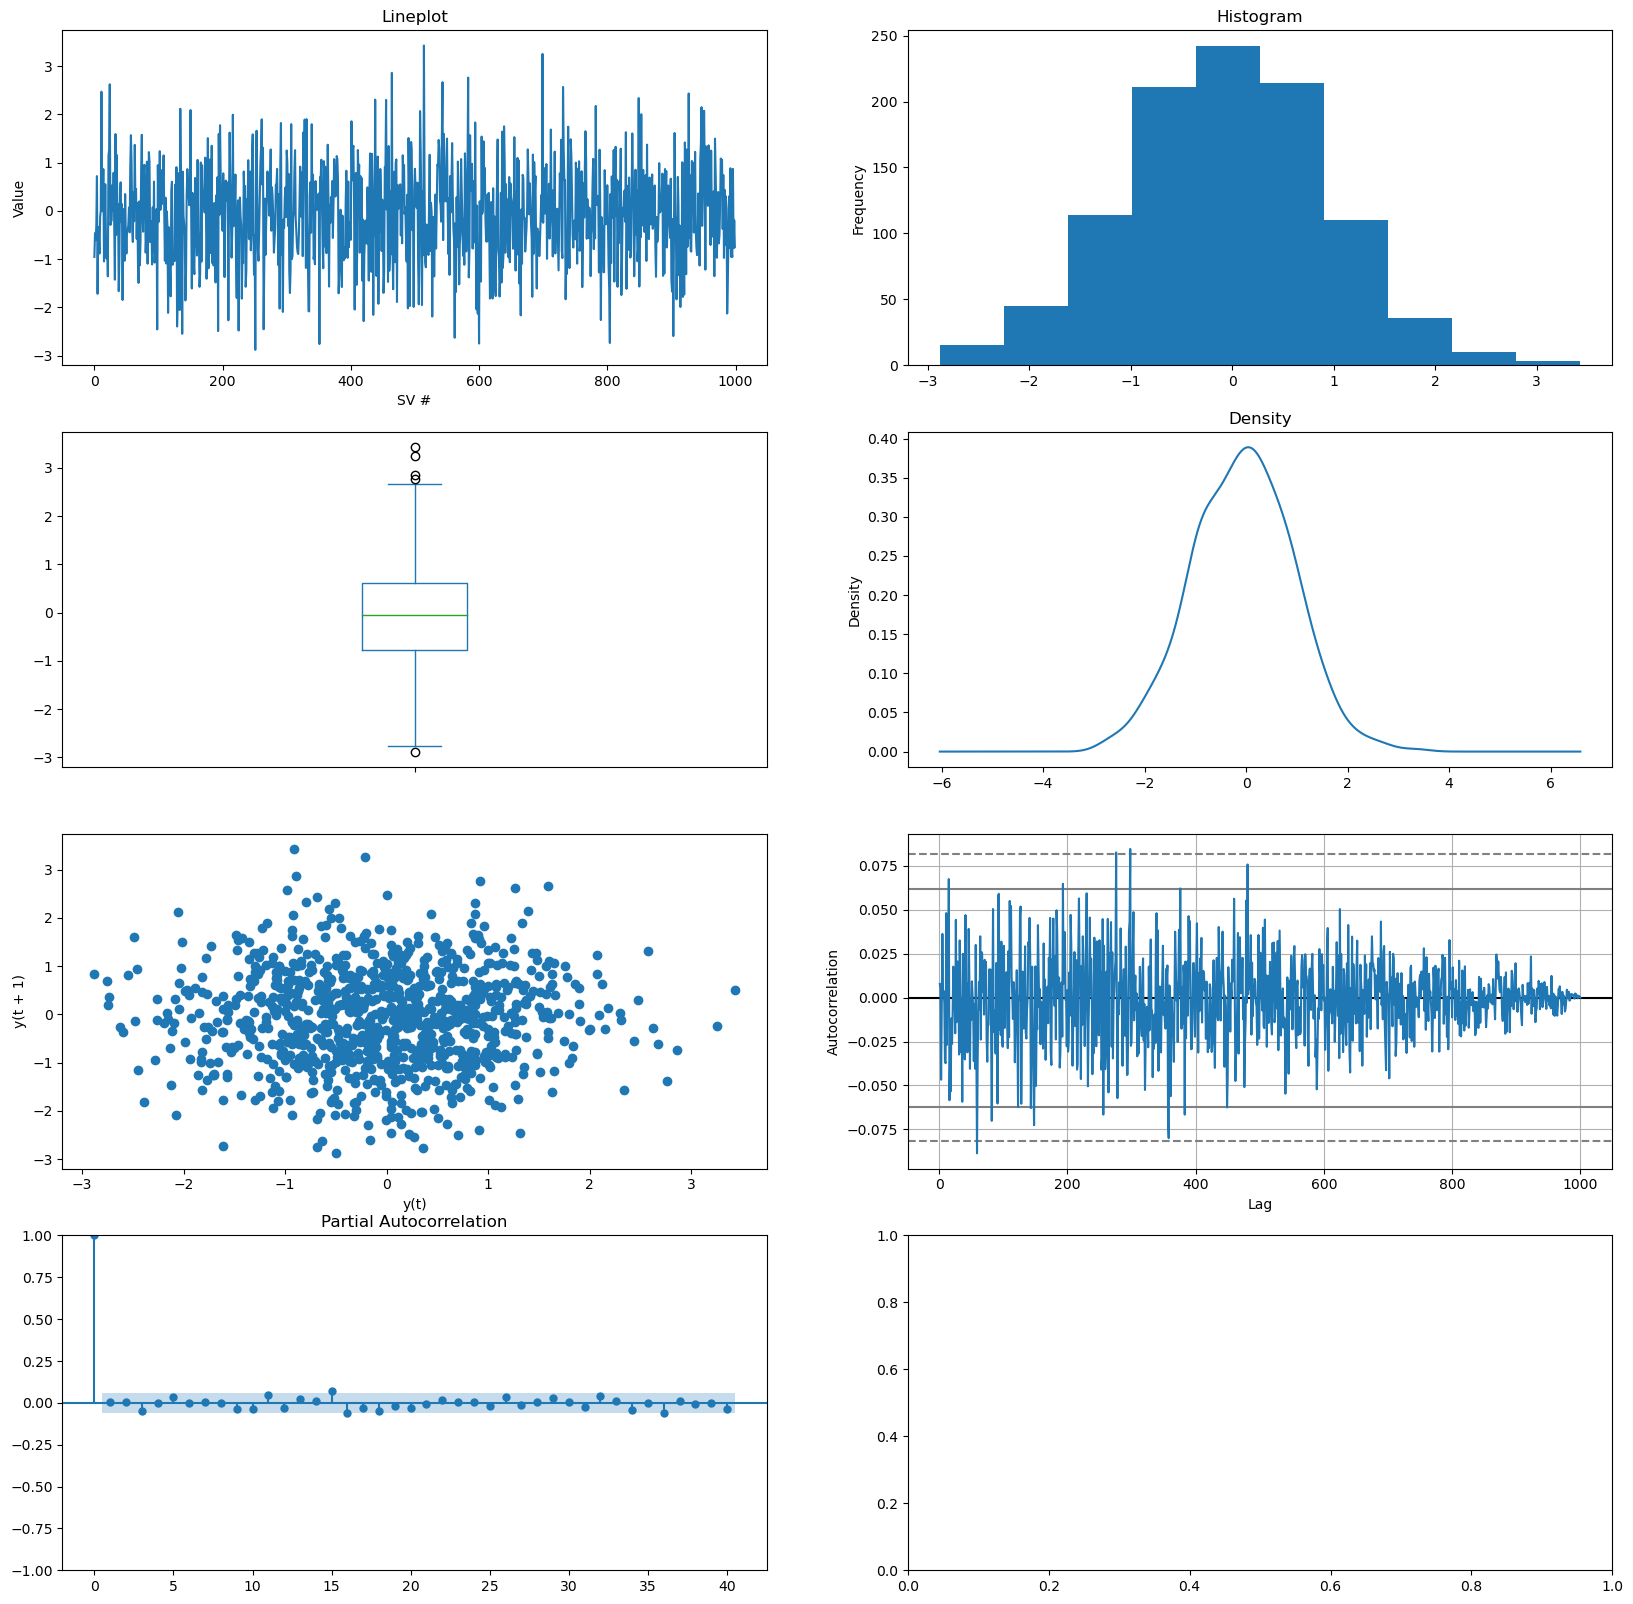

In [8]:
seed(10)
series = Series([gauss(0.0, 1.0) for _ in range(1000)])

print(f"MEAN:{series.mean()} STDDEV: {series.std()}")
plot_all(series, lags=40)

### Task 1.1.2 - Same as above but for the average of 100 random random series with 1000 data points each

MEAN: 0.0033041176413629446
STDDEV: 0.09791546516302142


/home/zanilicious/anaconda3/envs/IL2233/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


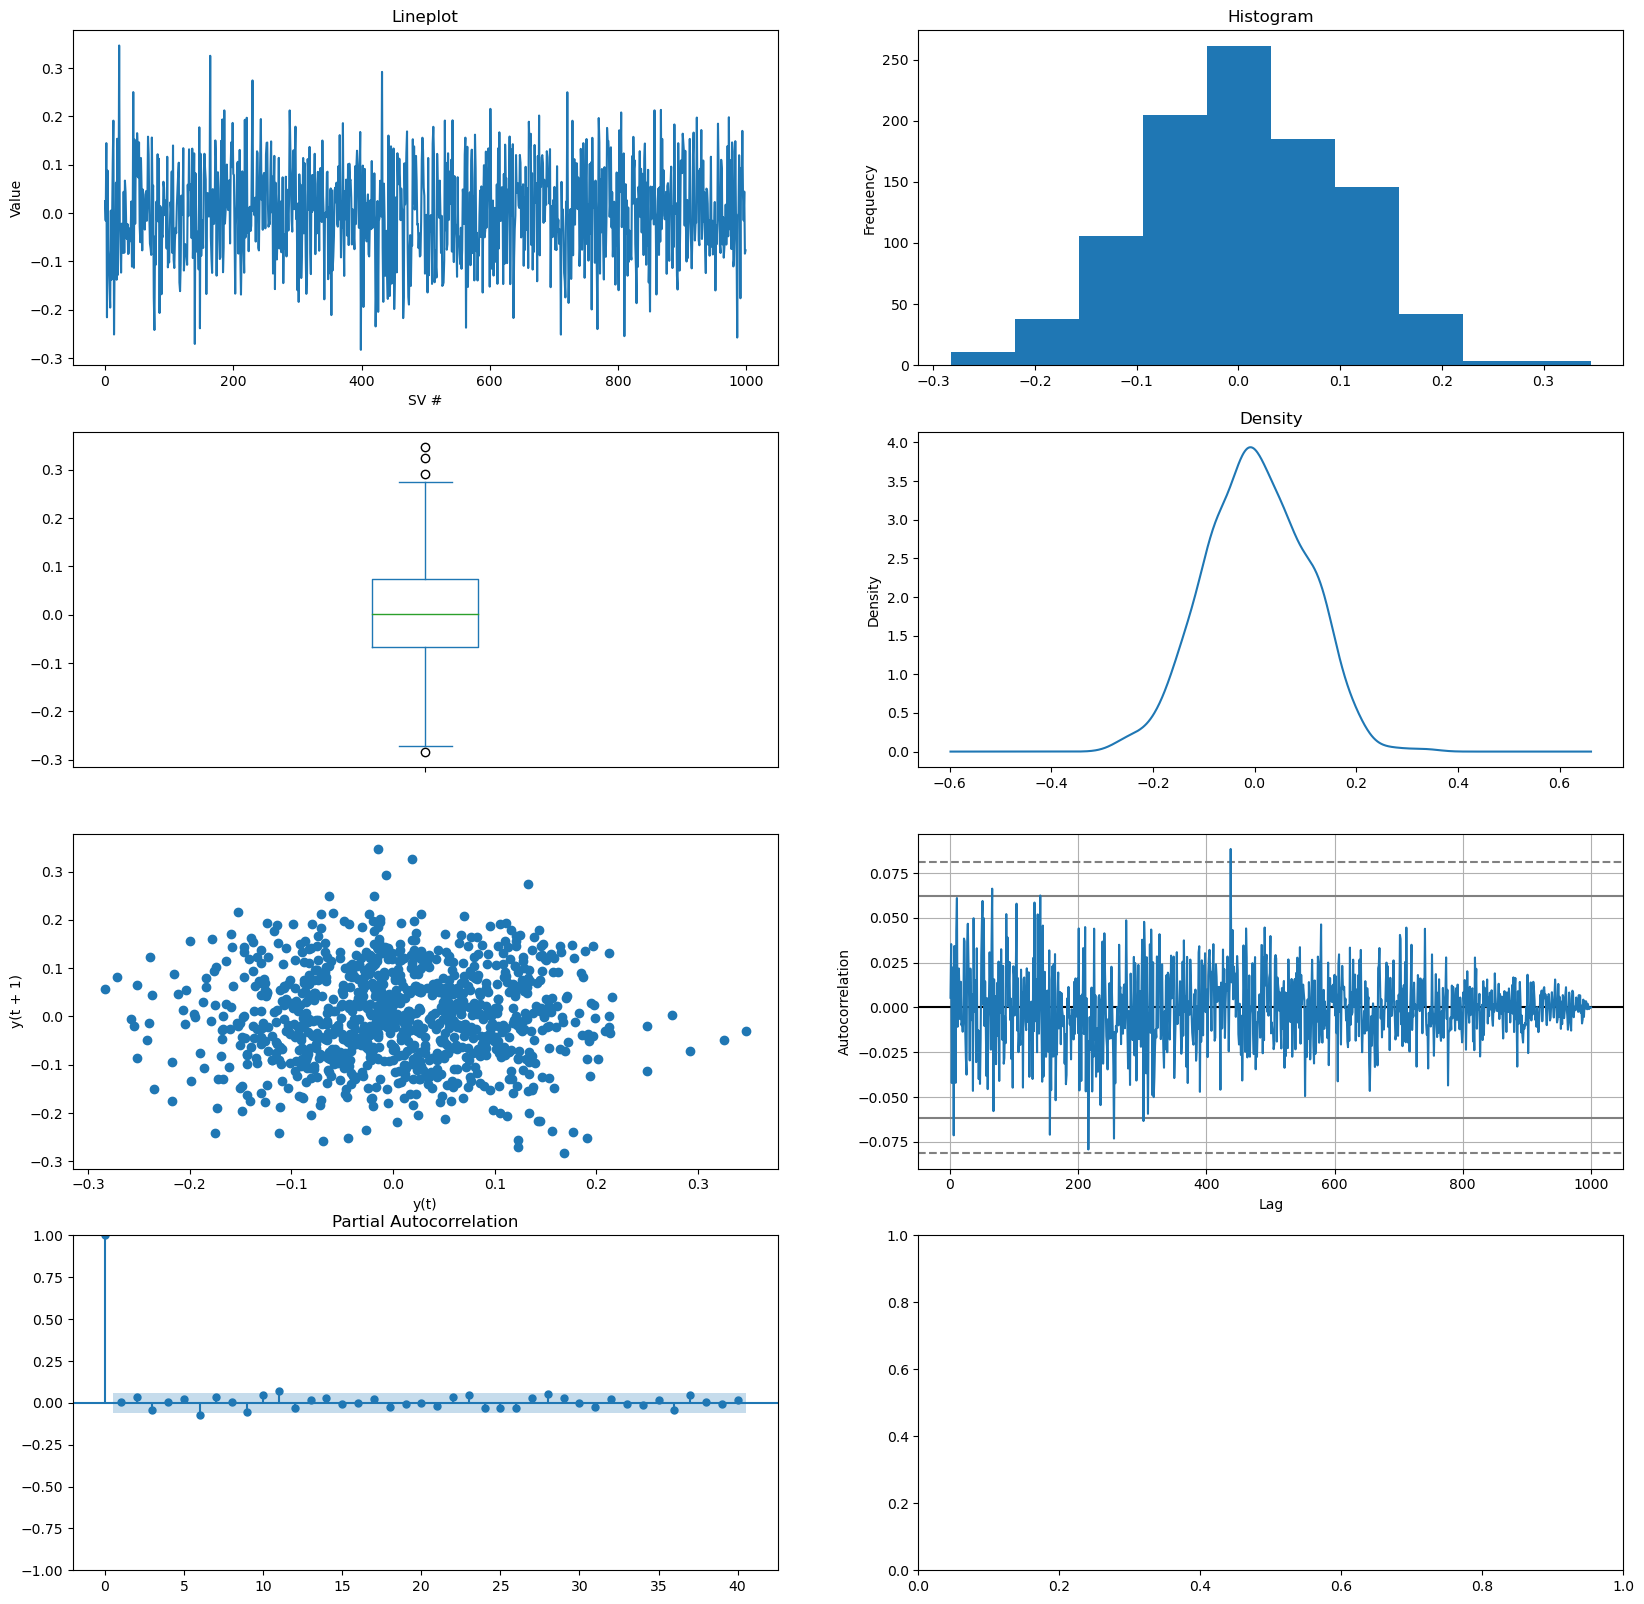

In [9]:
series_100 = [[gauss(0.0, 1.0) for _ in range(1000)] for _ in range(100)]
series_100_avg = []
for i in range(1000):
    sum = 0
    for j in range(100):
        sum += series_100[j][i]
    series_100_avg.append(sum / 100)
series_100_avg = Series(series_100_avg)

# Mean and standard deviation
print("MEAN:", series_100_avg.mean())
print("STDDEV:", series_100_avg.std())
plot_all(series_100_avg, 40)

### Task 1.1.3 - Randomness test with the Ljungbox test on the averaged series from previous task

The results below show that the calculated probabilities for the varying lag are set above the threshold of 0.05. It can be observed that the data is randomly distributed.

In [10]:
ljungbox(series_100_avg);

### Task 1.1.4 - Stationarity test with the ADF test on the averaged series from Task 1.1.2
For the results below, we find that the ADF statistic is lower than the critical values and that the p-value remains lower than significant value and thus we consider that the data is stationary

In [11]:
adfuller_test(series_100_avg)

ADF Statistic: -9.025475788812402
p-value: 5.6255555472623464e-15
Critial Values:
1%, -3.436979275944879
Critial Values:
5%, -2.8644668170148058
Critial Values:
10%, -2.5683283824496153


## Task 1.2 Random Walk Series

### Task 1.2.1, 1.2.2 - Generate a random walk series and show various plots on the data

/home/zanilicious/anaconda3/envs/IL2233/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


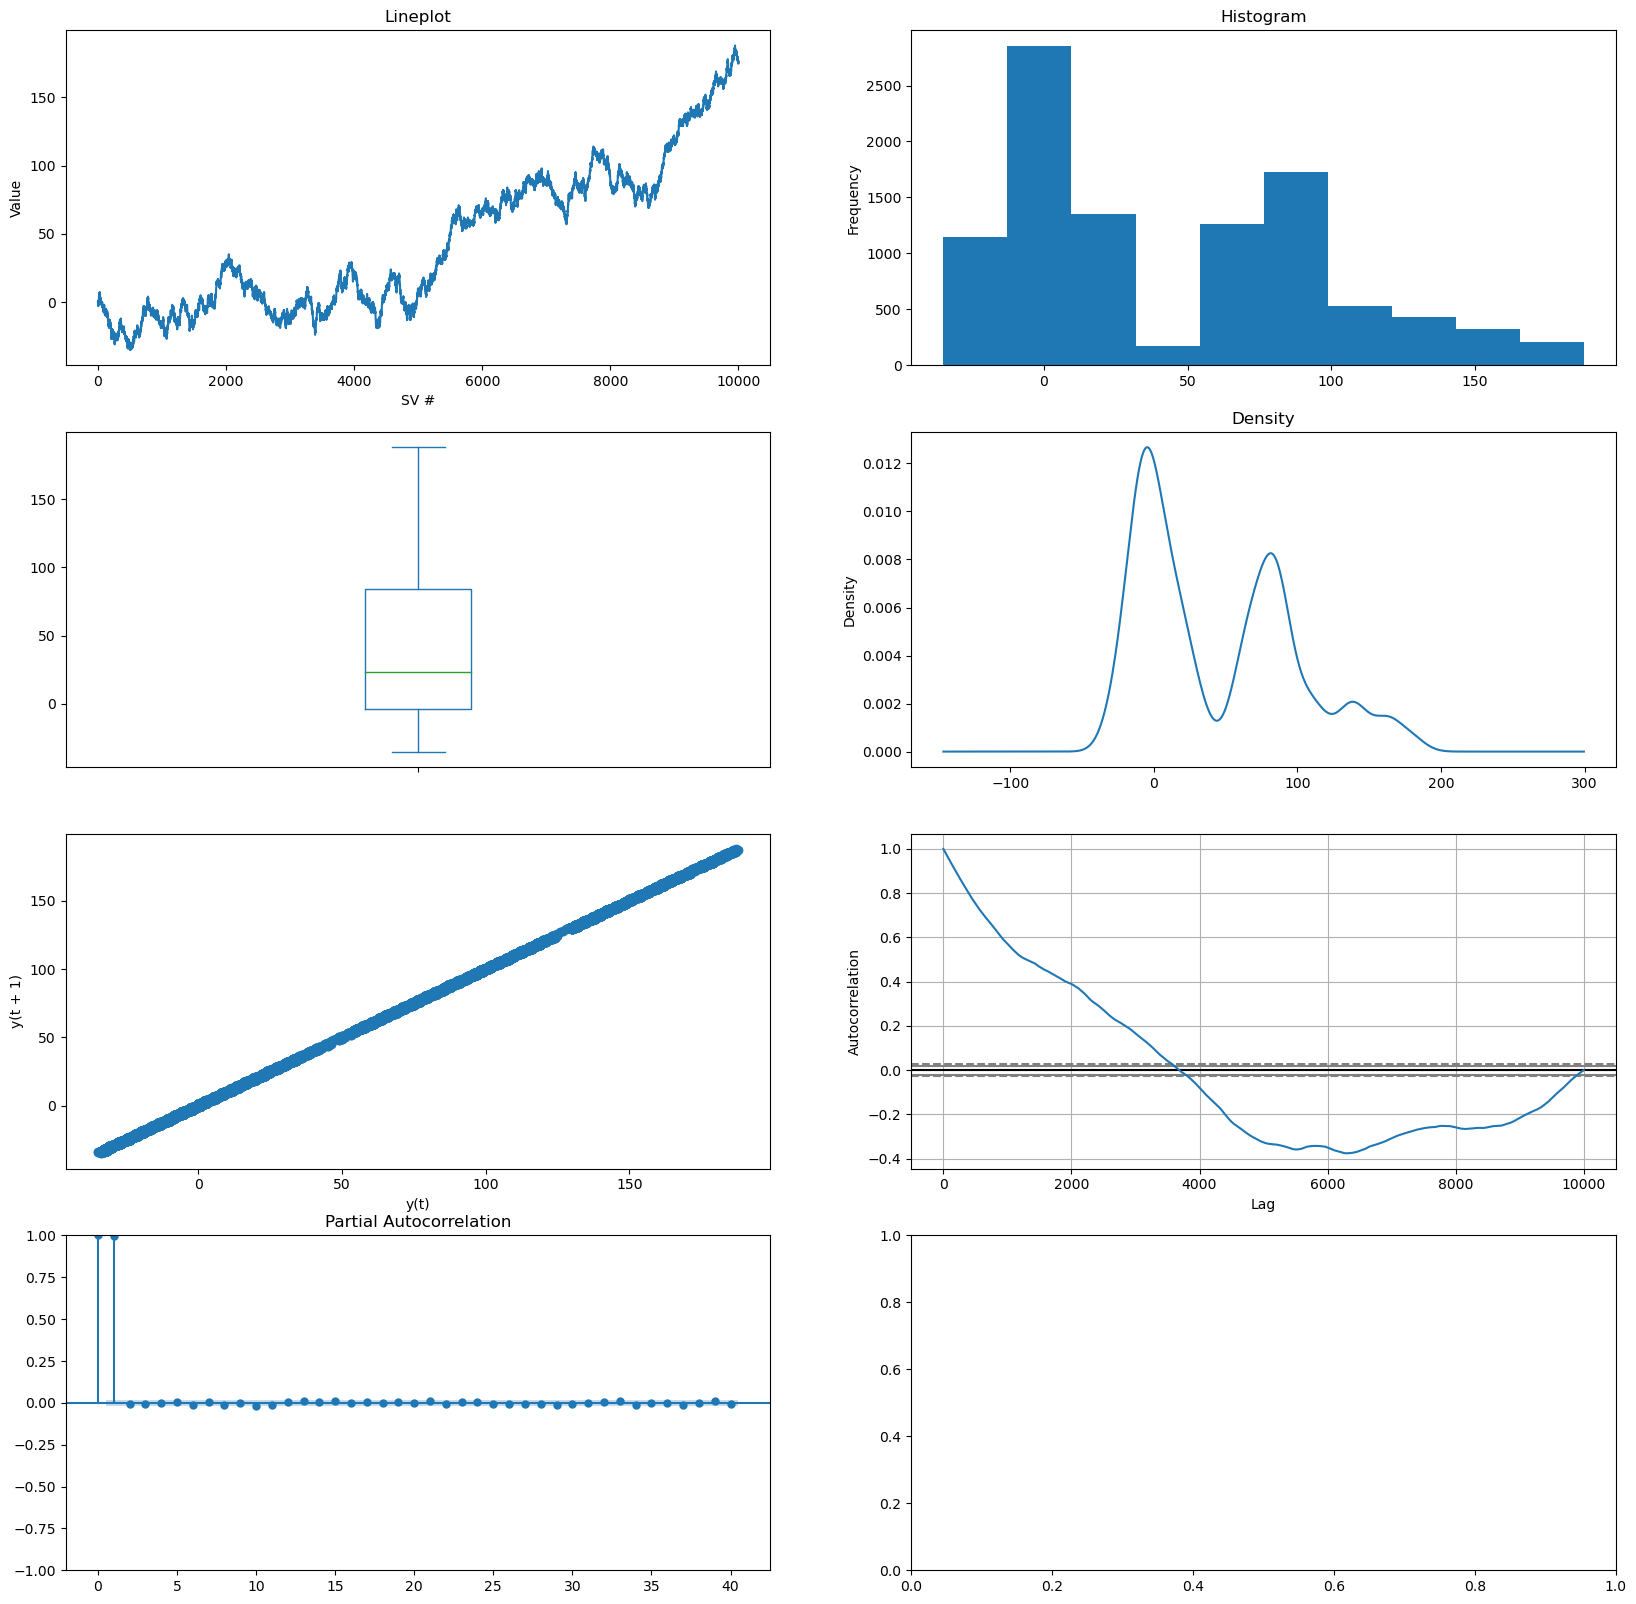

In [12]:
def random_walk(N: int) -> Series:
    series = [0]
    for _ in range(N-1):
        random_val = randint(0,1)
        if random_val == 0:
            random_val = -1
        series.append(series[-1] + random_val)
    
    return Series(series)

seed(time.time())

random_walk_series = random_walk(10000)
plot_all(random_walk_series, lags=40)

### Task 1.2.3 - Ljung Box Test

We see from the Ljungbox test that the series is dependent. This makes sense since the random walk series IS dependent and NOT random.

In [13]:
sm.stats.acorr_ljungbox(random_walk_series)

lb_stat  lb_pvalue
1    9992.997876        0.0
2   19976.920232        0.0
3   29951.637381        0.0
4   39917.127847        0.0
5   49873.514671        0.0
6   59820.591016        0.0
7   69758.478039        0.0
8   79687.012431        0.0
9   89606.156197        0.0
10  99515.577380        0.0

### Task 1.2.4 - Stationarity Test with ADF. Is it stationary? If not, how can it be made stationary?

 The ADF shows that the series is NOT stationary through the test statistics and the p-value. One possibility to make it stationary is to create a new series `z_t = y_t - y_t-1`, which would give constant mean and constant variaton which leads to stationary distribution.

In [14]:
adfuller_test(random_walk_series)

ADF Statistic: 0.4962734510145893
p-value: 0.9847593896571617
Critial Values:
1%, -3.4310041633725734
Critial Values:
5%, -2.861829101294412
Critial Values:
10%, -2.566923883481157


### Questions
- What methods can be used to check if a series is random? Describe both visualization and statistic test methods.

Visualization: If 95% of the values in the ACF and PACF plots are inside the critical values (blue background) then the time series is random (specifically, the series can't be distinguished from white noise).
Statistical: The Ljung-Box test checks for whether a series is random or not.

- What methods can be used to check if a series is stationary? Describe both visualization and statistic test methods.

Visualization: If the lag plot of a time series shows no discernible pattern with the values spread out, then the series is not stationary.
Statistical: The ADF test checks whether a series is stationary.

- Why is white noise important for time-series prediction?

The theory of White Noise is a critical tool for determining if the time series contains random noise, and further used to distinguish the random data from the valuable data. In decompositions of data we can sort out the random noise from the trend component and seasonal component in what gives us the residue component.

- What is the difference between a white noise series and a random walk series?

Whereas the White Noise series is random and each value is independent, the Random Walk series has each value depend on the previous value and a random value.

- Is it possible to change a random walk series into a series without correlation across its values ? If so, how? Explain also why it can.

Discussion question

## Task 1.3 - Global land temperature anomalies series

### Task 3.1.3.1, 1.3.2 - Read data and Plotting etc.

In [15]:
temp_anomalies: DataFrame = read_excel('global_land_temp_anomalies.xlsx', sheet_name=1, names=[None, "Year", "Anomaly"], usecols="B:C", skiprows=4)

/home/zanilicious/anaconda3/envs/IL2233/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/home/zanilicious/anaconda3/envs/IL2233/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


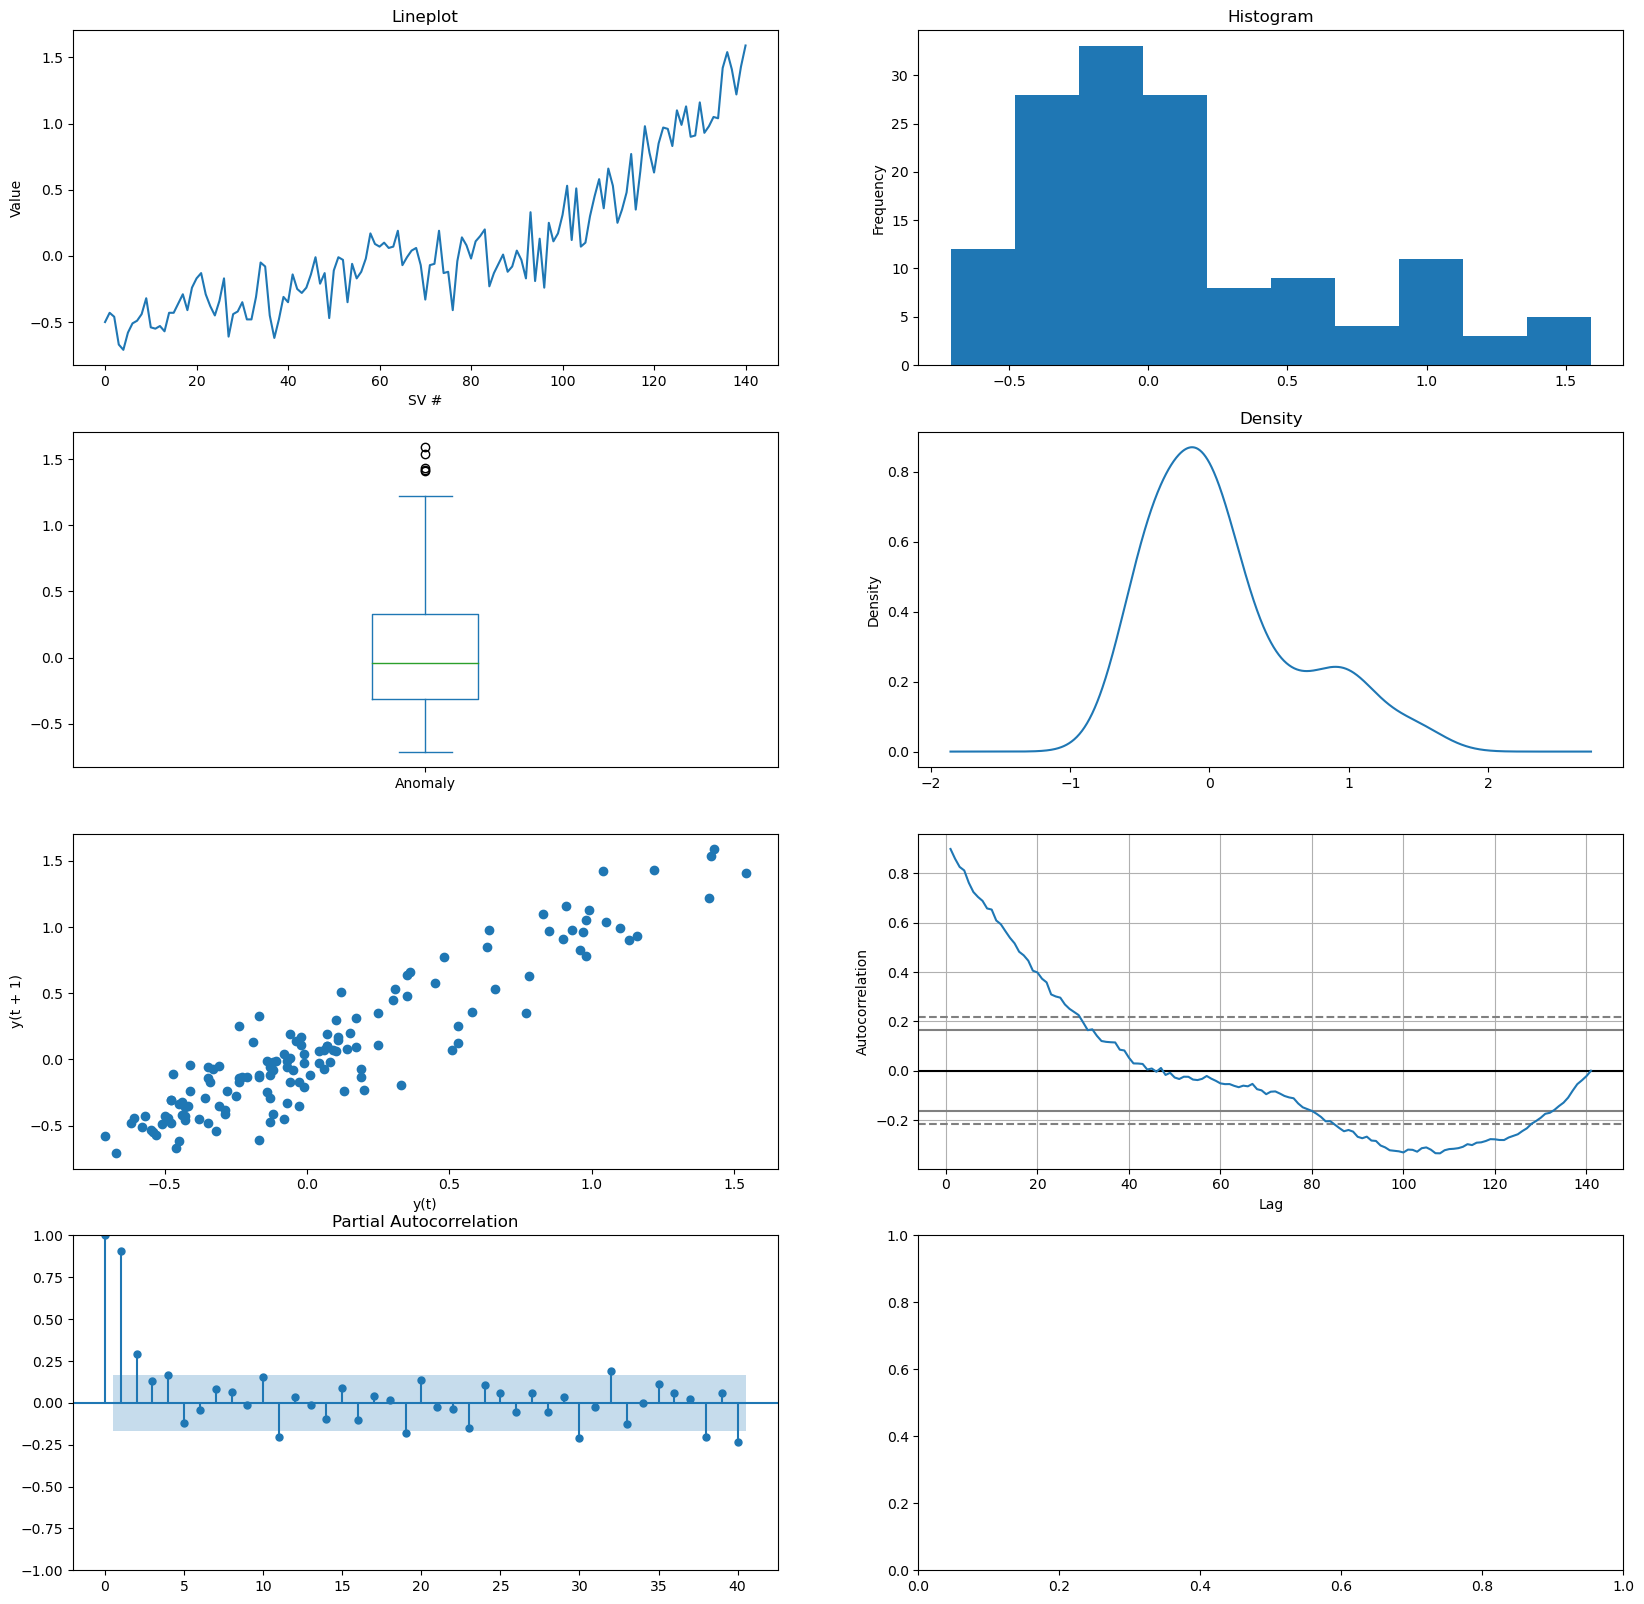

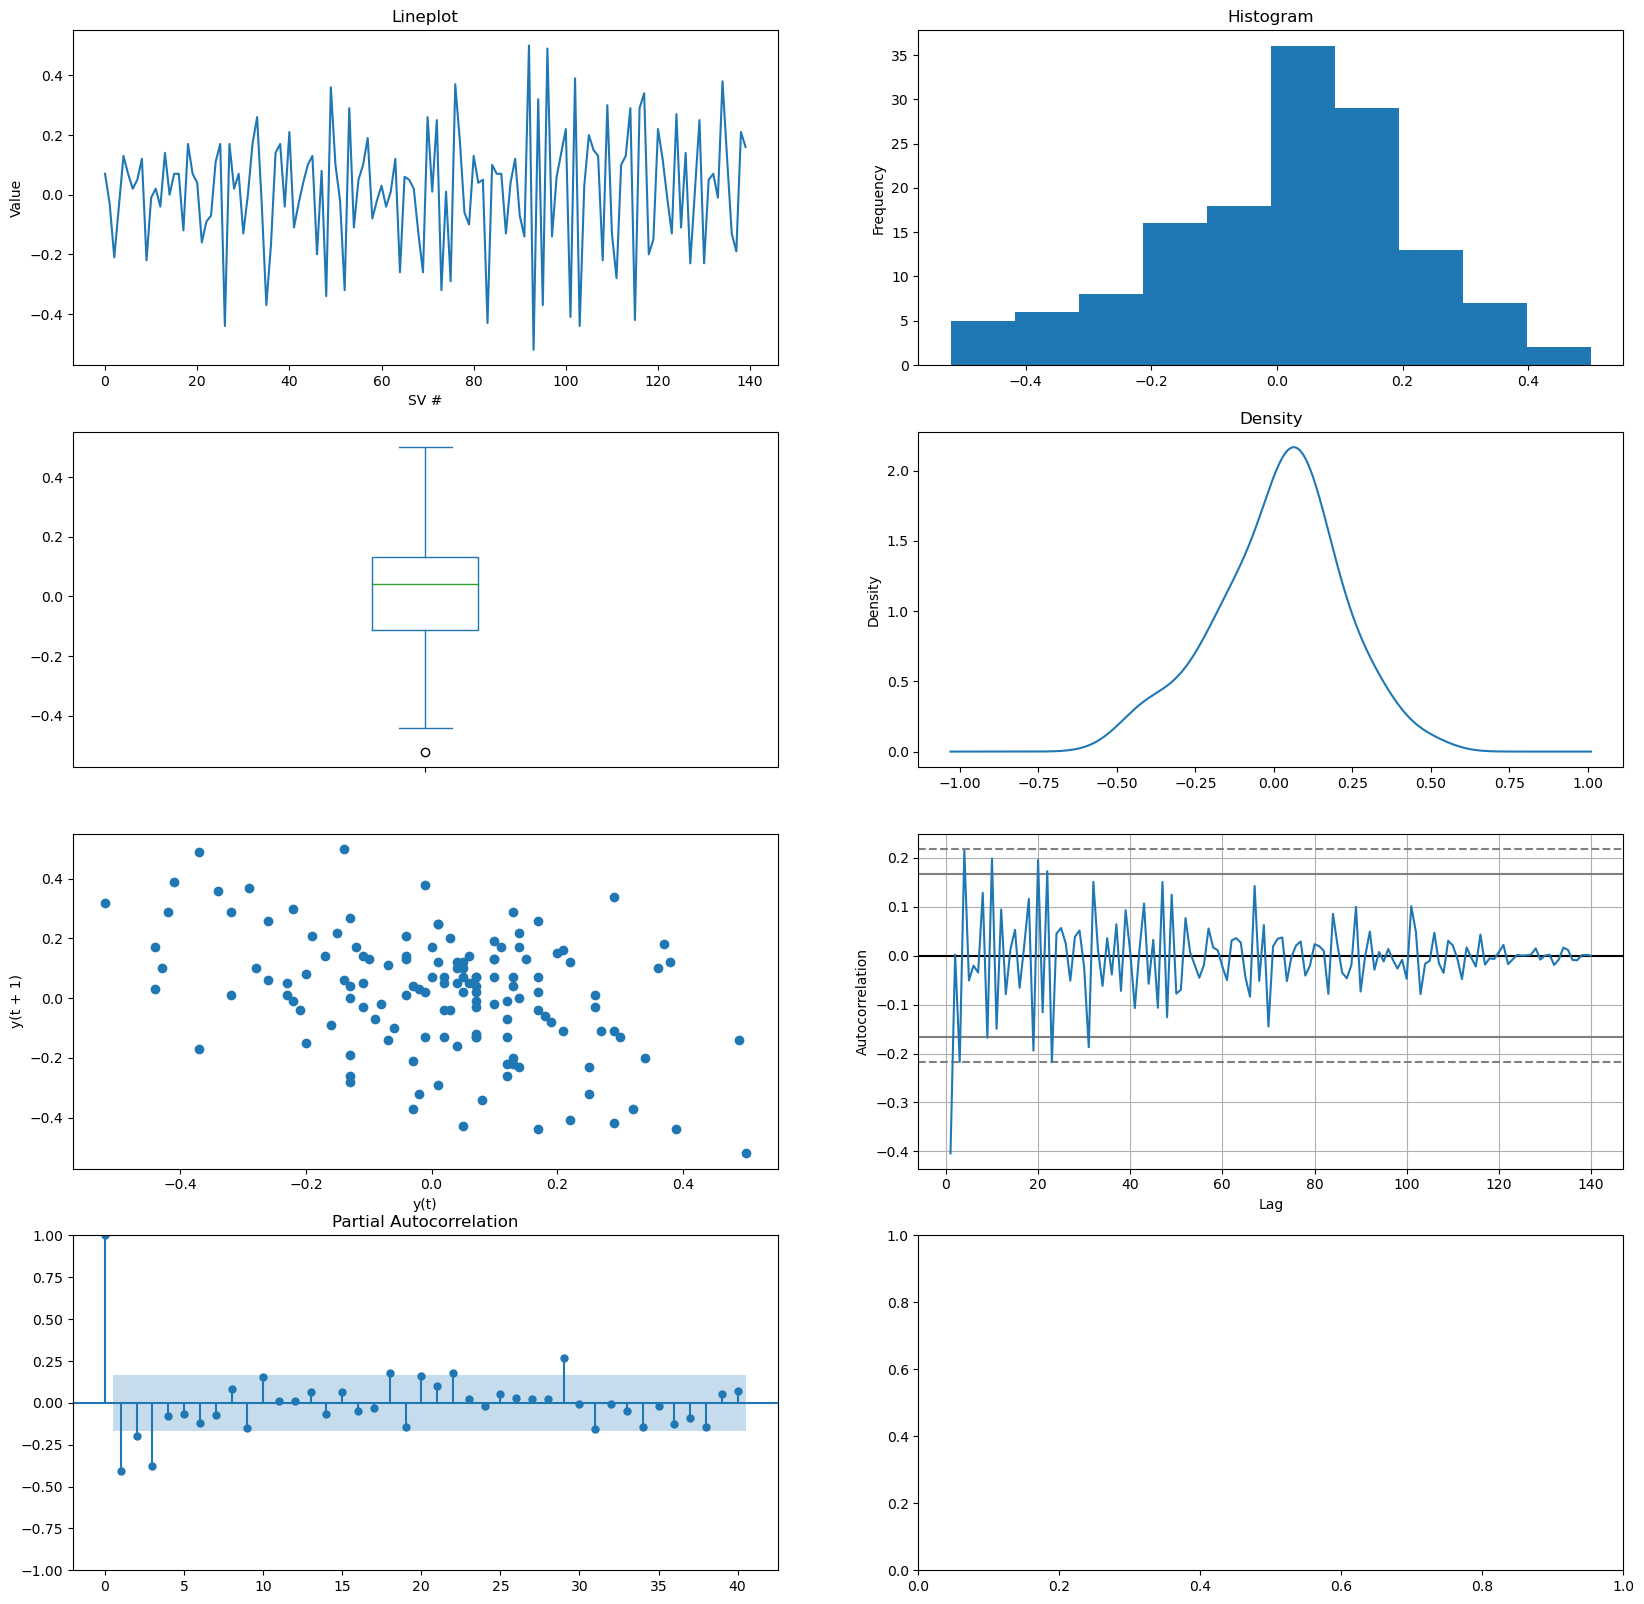

In [16]:
anomalies_series = Series(temp_anomalies['Anomaly'].squeeze())
fod_series = Series([anomalies_series[i] - anomalies_series[i-1] for i in range(1, len(anomalies_series))])
plot_all(anomalies_series, lags=40)
plot_all(fod_series, lags=40)

### Task 3.1.3.3 - Test if the first order difference series is random or not

It can be observed that the original temperature anomaly serires is not stationary because all critical values are below the ADF statistic.

In [17]:
ljungbox(anomalies_series)
ljungbox(fod_series)

lb_stat     lb_pvalue
1   23.320097  1.371594e-06
2   23.320603  8.629695e-06
3   30.150398  1.283094e-06
4   36.849474  1.934610e-07
5   37.229219  5.388000e-07
6   37.291533  1.544821e-06
7   37.471550  3.817995e-06
8   39.943228  3.282680e-06
9   44.211360  1.290320e-06
10  50.208598  2.443360e-07

### Task 3.1.3.4 - ADF Test to check if original and differenced series are stationary or not

It can be observed that the **first order difference** of the anomalies series makes the distribution stationary, since all critical values are above the ADF statistic.

In [18]:
adfuller_test(anomalies_series)
adfuller_test(fod_series)

ADF Statistic: 0.938292641937885
p-value: 0.993570249862259
Critial Values:
1%, -3.479007355368944
Critial Values:
5%, -2.8828782366015093
Critial Values:
10%, -2.5781488587564603
ADF Statistic: -12.165503286659847
p-value: 1.460486937213061e-22
Critial Values:
1%, -3.479007355368944
Critial Values:
5%, -2.8828782366015093
Critial Values:
10%, -2.5781488587564603


### Task 1.3.5 - Classical decomposition and STL decomposition on the first order difference series
Discussion question: Which period to use?

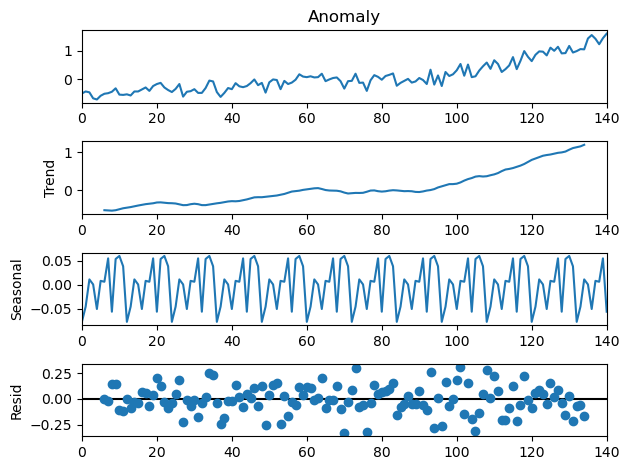

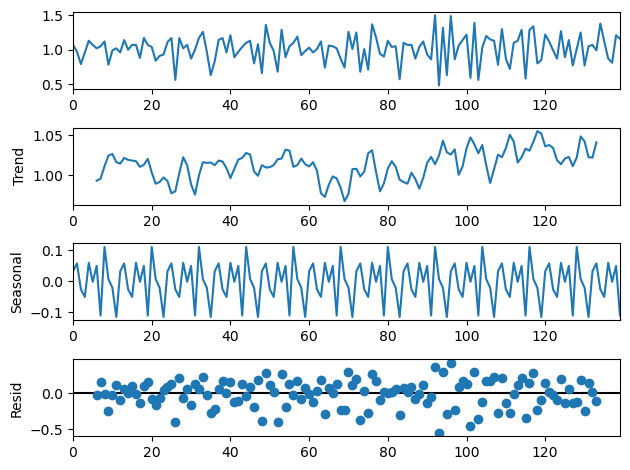

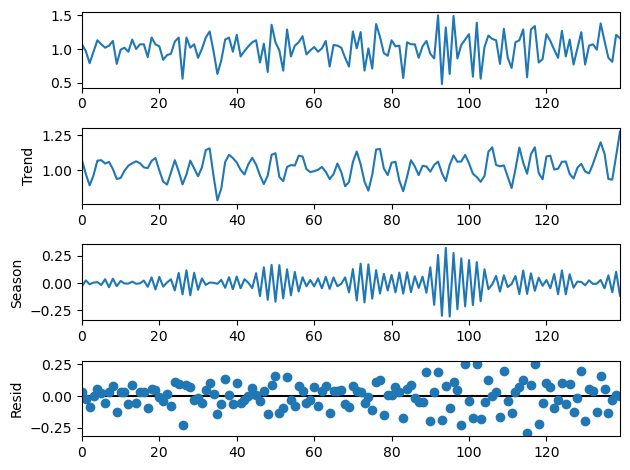

In [49]:
# WHICH PERIOD TO USE
result_anomaly = seasonal_decompose(anomalies_series, model="additive", period=12) # Not sure of period
result_fod = seasonal_decompose(fod_series.map(lambda x: x+1), model="additive", period=12) # Not sure of period
result_anomaly.plot();
result_fod.plot();
stl_result = STL(fod_series.map(lambda x: x+1), period=2)
stl_result.fit().plot();

### Questions
- What is a stationary time series?

Stationary refers to a mean and standard deviation being a constant both globally but also locally for the time series. Furthermore the time series can not be periodic, e.g. a sinus wave.

- If a series is not stationary, is it possible to transform it into a stationary one? If so, give one technique to do it?

Yes. By taking a first-order difference of the series it is possible to get a stationary one.

- Is the global land temperature anomaly series stationary? Why or why not?

There is instability in the temperature due to how the climate works. This leads to volatile anomalies which leads to non stationarity.

- Is the data set after the first-order difference stationary?

Yes.

- Why is it useful to decompose a time series into a few components? What are the typical components in a time-series decomposition?

The Trend, Seasonal, and Residual components are typical in a time-series decomposition. These various components can give us useful insight into the time series, e.g. the Residual component allows random noise to be put there.

# Task 2 - Feature Extraction

### Task 2.1 - Frequency components of a synthetic time-series signal
Data: Generate a series of five sequential sine wave signals for five seconds, each sine
wave lasting 1 second. The nth sine wave signal $x_n = sin(2π·n·f)$, where $f = 10$, and $n = 1, 2, 3, 4, 5$ i.e., frequency 10Hz, 20Hz, 30Hz, 40Hz and 50Hz. The series is digitalized
with a sampling rate is 200 Hz.



### Task 2.1.1 - Draw Line plot

<Axes: >

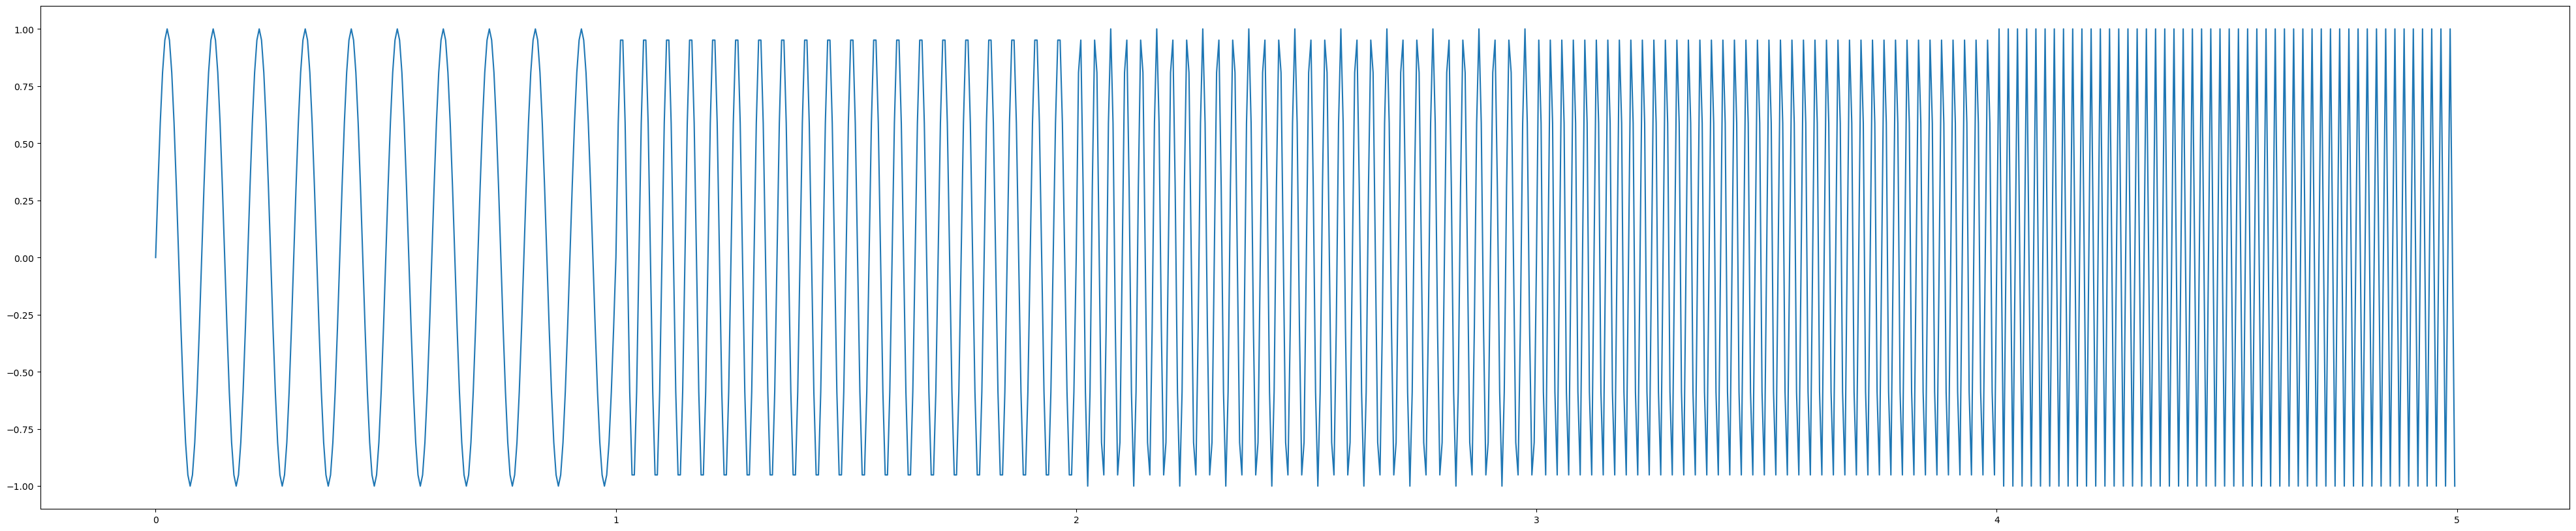

In [20]:
def gen_sine(freq_200_0_to_1) -> Series:
    sine_y = []
    for i in range(5):
        sine_y.extend(freq_200_0_to_1.map(
            lambda t: np.sin(2*np.pi*(i+1)*10*t)
        ))
    return Series(sine_y)

x_wave = []
timestamps = Series(np.linspace(0, 0.995, 200))
y_values = gen_sine(timestamps)
y_values.index = np.linspace(0, 4.995, 1000)
y_values.plot(figsize = (50, 10), kind='line')

### Task 2.1.2 Display the power spectrum (power density graph) of the series

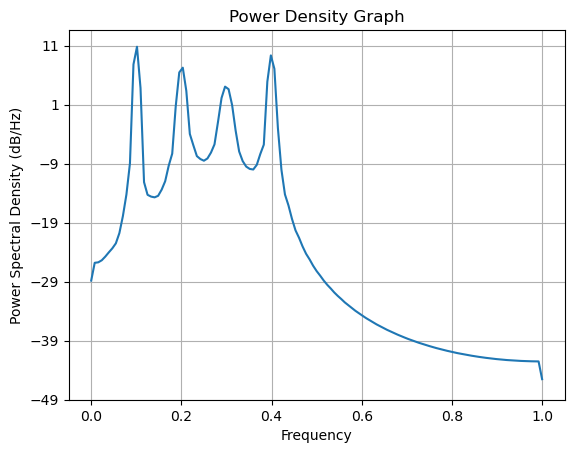

In [21]:
# Power density graph
plt.psd(y_values);
plt.title("Power Density Graph");

### Task 2.1.3 Draw a spectogram of the series

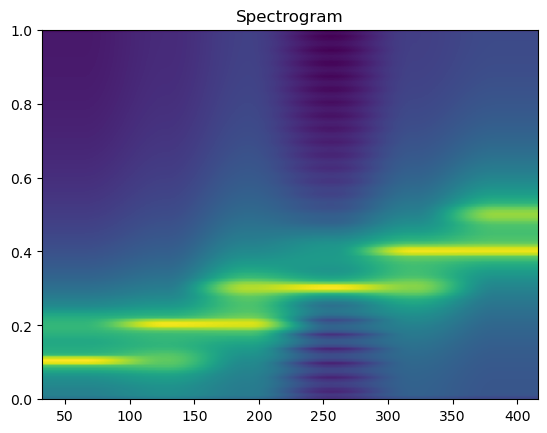

In [22]:
# Spectrogram
plt.specgram(y_values);
plt.title("Spectrogram");

### Task 2.1.4 Draw and compare the ACF and PACF graphs of the first one-second (frequency 10Hz) and the second one-second series (frequency 20Hz), with lags up to 50.

/home/zanilicious/anaconda3/envs/IL2233/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


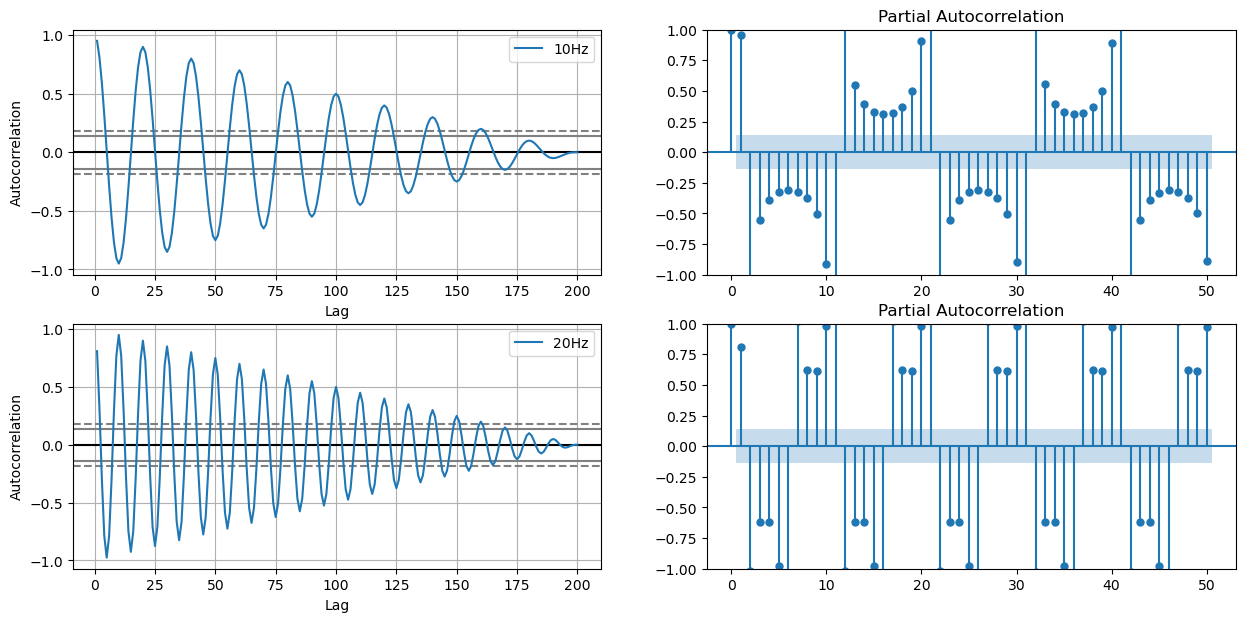

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 7))
fig.subplots_adjust()
autocorrelation_plot(y_values.iloc[0:200], label='10Hz', ax=axes[0,0]);
plot_pacf(y_values.iloc[0:200], lags=50, label='10Hz', ax=axes[0,1]);
autocorrelation_plot(y_values.iloc[200:400], label='20Hz', ax=axes[1,0]);
plot_pacf(y_values.iloc[200:400], lags=50, label='20Hz', ax=axes[1,1]);

By inspecting the plots we can see that neither of the two intervals are stationary time series. This is due to the ACF which is outside the 5% and 10% boundaries. We also know by theory that periodic time series are not stationary. Regarding PACF there is a strange pattern for the 10Hz time series that is not repeated for the other frequencies. The results are expected since the sine wave is repeating according to its frequency and we see strong correlation between the data points.

## Task 2.2 - Statistical features and discovery of event-related potential (ERP)

### Task 2.2.1 - Visuallize the event related potential (ERP) in the two conditions A and B

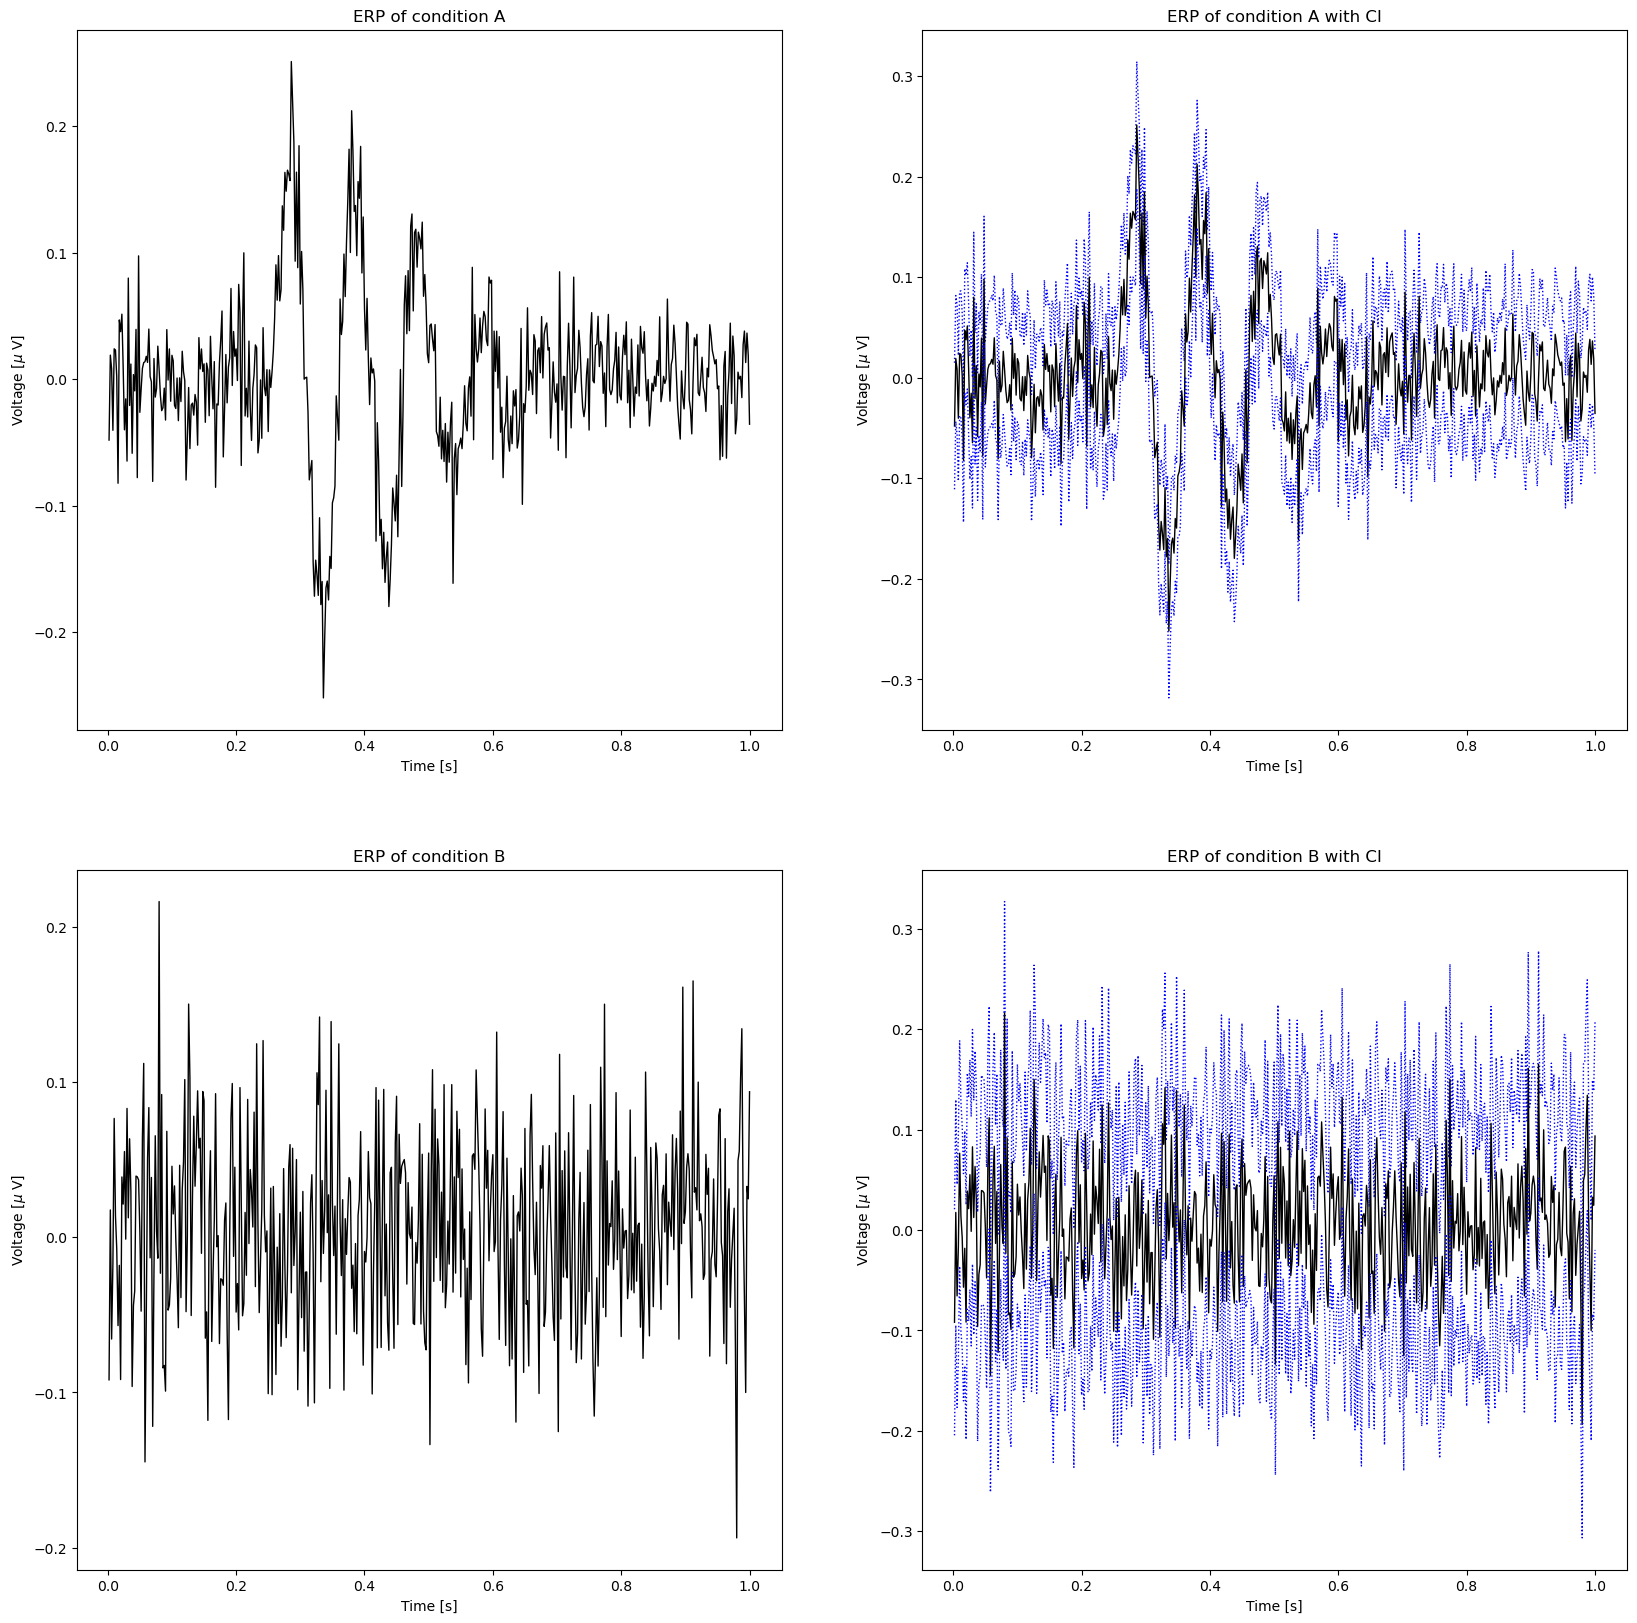

In [24]:
data: dict = loadmat('02_EEG-1.mat')
EEGa = data['EEGa']                                   # numpy.ndarray
EEGb = data['EEGb']                                   # numpy.ndarray
t = data['t'][0]                                      # numpy.ndarray
ntrials_a = len(EEGa)
ntrials_b = len(EEGa)
average_a = EEGa.mean(0)                    # Mean values at each time instance over the 1000 trials
average_b = EEGb.mean(0)
variance_a = EEGa.std(0)                    # Compute the std of the signal across trials.
variance_b = EEGb.std(0)
stddev_a = variance_a / sqrt(ntrials_a)     # Compute the std of the mean.
stddev_b = variance_b / sqrt(ntrials_b)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
fig.subplots_adjust()

axes[0,0].set_title('ERP of condition A')
axes[0,0].set_xlabel('Time [s]')
axes[0,0].set_ylabel('Voltage [$\mu$ V]')
axes[0,1].set_title('ERP of condition A with CI')
axes[0,1].set_xlabel('Time [s]')
axes[0,1].set_ylabel('Voltage [$\mu$ V]')
axes[1,0].set_title('ERP of condition B')
axes[1,0].set_xlabel('Time [s]')
axes[1,0].set_ylabel('Voltage [$\mu$ V]')
axes[1,1].set_title('ERP of condition B with CI')
axes[1,1].set_xlabel('Time [s]')
axes[1,1].set_ylabel('Voltage [$\mu$ V]')

axes[0,0].plot(t, average_a, 'k-', lw=1)
axes[1,0].plot(t, average_b, 'k-', lw=1)

axes[0,1].plot(t, average_a + 2 * stddev_a, 'b:', lw=1)  # 95% upper confidence interval
axes[0,1].plot(t, average_a, 'k-', lw=1)                 # Plot the ERP of condition A,
axes[0,1].plot(t, average_a - 2 * stddev_a, 'b:', lw=1)  # 95% lower confidence interval, 2 std from mean

axes[1,1].plot(t, average_b + 2 * stddev_b, 'b:', lw=1)  # 95% upper confidence interval
axes[1,1].plot(t, average_b, 'k-', lw=1)                 # Plot the ERP of condition A,
axes[1,1].plot(t, average_b - 2 * stddev_b, 'b:', lw=1)  # 95% lower confidence interval, 2 std from mean

plt.show()    
#savefig('imgs/2-2a')

## Task 2.2.1 - Find the brain activity frequency in the data of condition A
Discussion question: What does this question refer to?

## Task 2.3 Features of observed rhythms in EEG

### Task 2.3.1, 2.3.2 - Various plots of the EEG data and computing statistical properties on the data

/home/zanilicious/anaconda3/envs/IL2233/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


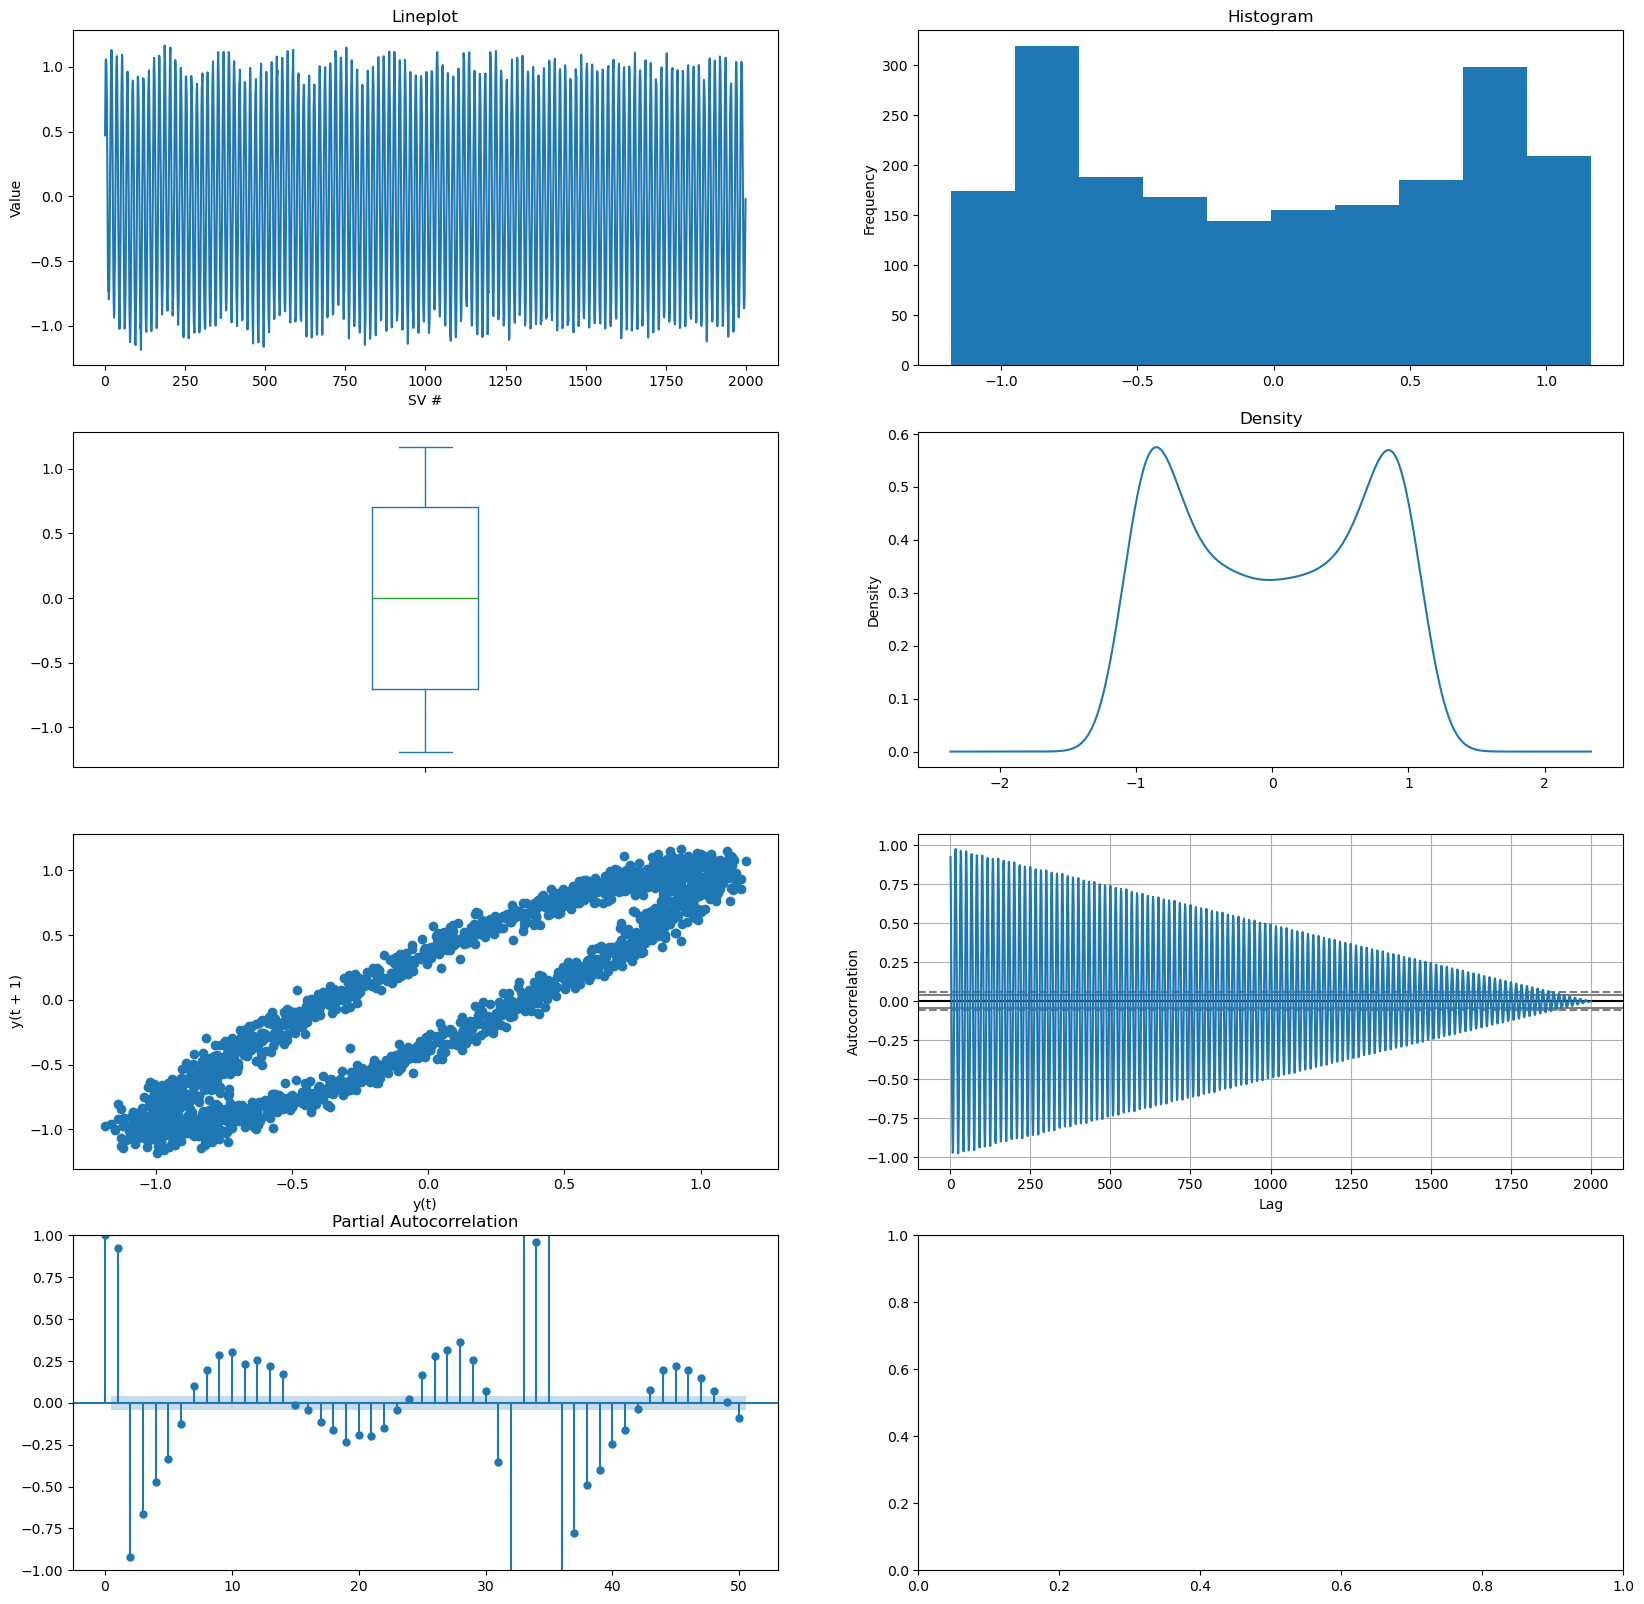

In [26]:
data: dict = loadmat('03_EEG-1.mat') # EEG = 2000 data points
EEG = np.transpose(data['EEG'])
np.shape(EEG)
plot_all(Series(EEG[0]), lags=50)

ntrials = len(EEG[0])
avg = EEG.mean()
variance = EEG.std()                 # Compute the std of the signal across trials.
stddev = variance / sqrt(ntrials)    # Compute the std of the mean.
# f'Mean: {avg}, Variance: {variance},
# Stddev: {variance / sqrt(ntrials)}'

### Task 2.3.3 - Compute the auto-covariance of the EEG data. Draw and save the auto-covariance graph.

### Question - Why does the auto-covariance exhibit repeated peaks and troughs approximately every 0.0166 s?
The reason for the peaks at about 60Hz is because it hits the gamma band of cognitive activity in the brain, which is around 40-80hz and here it can be observed at 60Hz.

### Task x.x.x

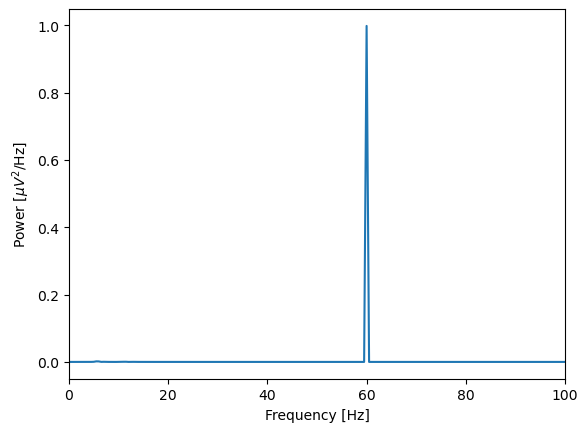

In [27]:
data = loadmat('03_EEG-1.mat')        # Load the EEG data
EEG = data['EEG'].reshape(-1)         # Extract the EEG variable
t = data['t'][0]                      # ... and the t variable

x = EEG                               # Relabel the data variable
dt = t[1] - t[0]                      # Define the sampling interval
N = x.shape[0]                        # Define the total number of data points
T = N * dt                            # Define the total duration of the data

xf = fft(x - x.mean())                # Compute Fourier transform of x
Sxx = 2 * dt ** 2 / T * (xf * xf.conj())  # Compute spectrum
Sxx = Sxx[:int(len(x) / 2)]           # Ignore negative frequencies

df = 1 / T.max()                      # Determine frequency resolution
fNQ = 1 / dt / 2                      # Determine Nyquist frequency
faxis = np.arange(0,fNQ,df)              # Construct frequency axis

plt.plot(faxis, Sxx.real)                 # Plot spectrum vs frequency
plt.xlim([0, 100])                        # Select frequency range
plt.xlabel('Frequency [Hz]')              # Label the axes
plt.ylabel('Power [$\mu V^2$/Hz]')
plt.show()

/home/zanilicious/anaconda3/envs/IL2233/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


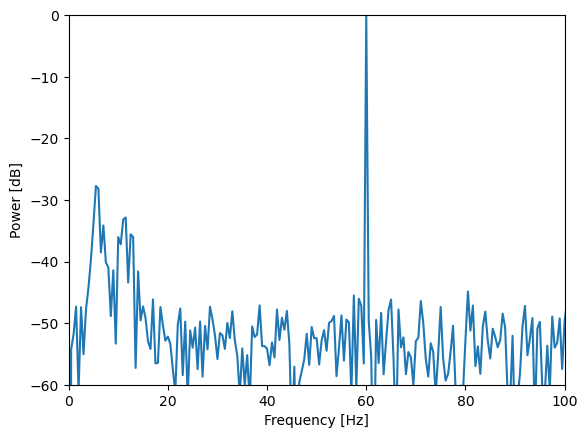

In [28]:
plt.plot(faxis, 10 * np.log10(Sxx / max(Sxx)))  # Plot the spectrum in decibels.
plt.xlim([0, 100])                           # Select the frequency range.
plt.ylim([-60, 0])                           # Select the decibel range.
plt.xlabel('Frequency [Hz]')                 # Label the axes.
plt.ylabel('Power [dB]')
plt.show()

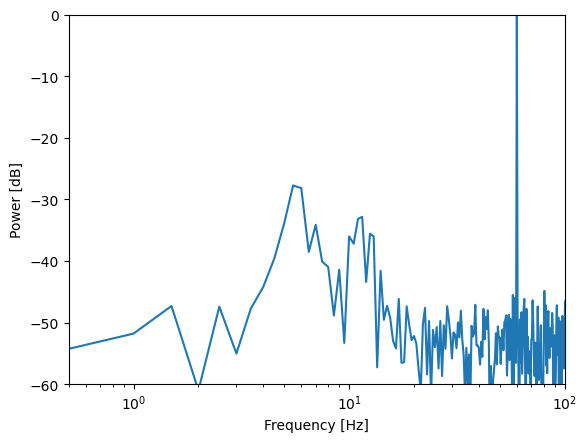

In [29]:
plt.semilogx(faxis, 10 * np.log10(Sxx / max(Sxx)))  # Log-log scale
plt.xlim([df, 100])                              # Select frequency range
plt.ylim([-60, 0])                               # ... and the decibel range.
plt.xlabel('Frequency [Hz]')                     # Label the axes.
plt.ylabel('Power [dB]')
plt.show()

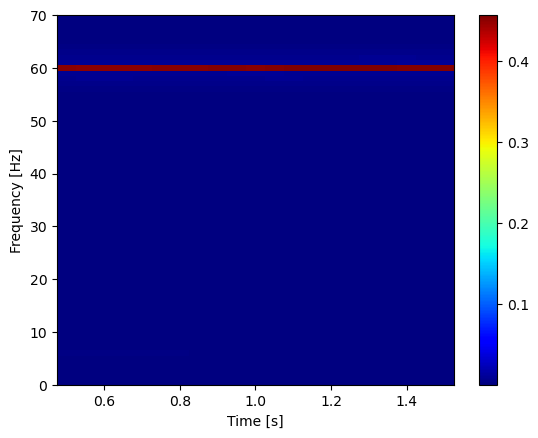

In [30]:
Fs = 1 / dt               # Define the sampling frequency,
interval = int(Fs)        # ... the interval size,
overlap = int(Fs * 0.95)  # ... and the overlap intervals

                          # Compute the spectrogram
f, t, Sxx = spectrogram(
    EEG,                  # Provide the signal,
    fs=Fs,                # ... the sampling frequency,
    nperseg=interval,     # ... the length of a segment,
    noverlap=overlap)     # ... the number of samples to overlap,
plt.pcolormesh(t, f, Sxx,
               cmap='jet')# Plot the result
plt.colorbar()                # ... with a color bar,
plt.ylim([0, 70])             # ... set the frequency range,
plt.xlabel('Time [s]')        # ... and label the axes
plt.ylabel('Frequency [Hz]')
plt.show()

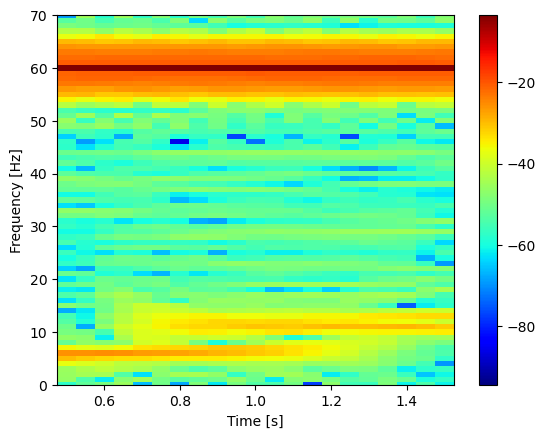

In [31]:
Fs = 1 / dt               # Define the sampling frequency,
interval = int(Fs)        # ... the interval size,
overlap = int(Fs * 0.95)  # ... and the overlap intervals

                          # Compute the spectrogram
f, t, Sxx = spectrogram(
    EEG,                  # Provide the signal,
    fs=Fs,                # ... the sampling frequency,
    nperseg=interval,     # ... the length of a segment,
    noverlap=overlap)     # ... the number of samples to overlap,
plt.pcolormesh(t, f, 10 * np.log10(Sxx),
               cmap='jet')# Plot the result
plt.colorbar()                # ... with a color bar,
plt.ylim([0, 70])             # ... set the frequency range,
plt.xlabel('Time [s]')        # ... and label the axes
plt.ylabel('Frequency [Hz]')
plt.show()

### Questions
- What features do you typically consider useful for analyzing and modeling time-series data?

- What features are specific for time-series, and what are general for both time-series and non-time-series data?

- How are auto-covariance and auto-correlation are defined for a time series? Give mathematical formulas for the definitions.

- Assume a short time-series {1, 2, 3, 4, 5, 6, 7, 8, 7, 6, 5, 4, 3, 2, 1}. First, calculate the auto-covariance and auto-correlations for all valid lags. Do the calculations manually. Then write a Python program to validate your calculations. Lastly, draw the ACF graph for the time series.

### Task 2.3.4 - Plot the power spectrum of the EEG data in both linear and logarithmic scale. Change the scale to decibels too to emphazise low-amplitude rythms.

# Keypoints:
* Ljung-Box test: Statistical test that checks if a time series is random. Does this with a hypothesis test where the pvalue determines this.
* Augmented Dickey-Fuller test: Statistical test checks if time series is stationary. Does this with hypothesis test, where test statistic AND pvalue are controlled.
* White Noise Series: Time series with independent variables and identically distributed with a mean of zero.
* Random Walk Series: Time series with dependent values, where current value depends equals previous value + random variable.

# Discussion Questions:
* What period to use for the seasonal decompose?
* What is brain activity frequency referring to?
* Can we change a random walk series into a series without correlation? What if we remove $y(t_1)$ for each value? Will the random variable X give us a non-correlating series? What if it's a simple symmetric time series?

yes! Do a fod